 # Submission instructions

 All code that you write should be in this notebook.
 Submit:

 * This notebook with your code added. Make sure to add enough documentation.
 * A short report, max 2 pages including any figures and/or tables (it is likely that you won't need the full 2 pages). Use [this template](https://www.overleaf.com/read/mvskntycrckw).
 * The deadline is Monday 17th of May, 17.00.

 For questions, make use of the "Lab" session (see schedule).
 Questions can also be posted to the MS teams channel called "Lab".


 # Installing AIF360

 In this assignment, we're going to use the AIF360 library.
 For documentation, take a look at:

     * https://aif360.mybluemix.net/
     * https://aif360.readthedocs.io/en/latest/ (API documentation)
     * https://github.com/Trusted-AI/AIF360 Installation instructions

 We recommend using a dedicated Python environment for this assignment, for example
 by using Conda (https://docs.conda.io/en/latest/).
 You could also use Google Colab (https://colab.research.google.com/).

 When installing AIF360, you only need to install the stable, basic version (e.g., pip install aif360)
 You don't need to install the additional optional dependencies.

 The library itself provides some examples in the GitHub repository, see:
 https://github.com/Trusted-AI/AIF360/tree/master/examples.

 **Notes**
 * The lines below starting with ! can be used in Google Colab by commenting them out, or in your console
 * The first time you're running the import statements, you may get a warning "No module named tensorflow".
   This can be ignored--we don't need it for this assignment. Just run the code block again, and it should disappear

In [1]:
# !pip install aif360
# !pip install fairlearn

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.datasets import Dataset
from aif360.datasets.structured_dataset import StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

get_ipython().run_line_magic('matplotlib', 'inline')


 # Exploring the data

 **COMPAS dataset**

 In this assignment we're going to use the COMPAS dataset.

 If you haven't done so already, take a look at this article: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.
 For background on the dataset, see https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

 **Reading in the COMPAS dataset**

 The AIF360 library has already built in code to read in this dataset.
 However, you'll first need to manually download the COMPAS dataset
 and put it into a specified directory.
 See: https://github.com/Trusted-AI/AIF360/blob/master/aif360/data/raw/compas/README.md.
 If you try to load in the dataset for the first time, the library will give you instructions on the steps to download the data.

 The protected attributes in this dataset are 'sex' and 'race'.
 For this assignment, we'll only focus on race.

 The label codes recidivism, which they defined as a new arrest within 2 years.
 Note that in this dataset, the label is coded with 1 being the favorable label.

In [2]:
get_ipython().system(
    'curl https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv --output compas-scores-two-years.csv'
)
get_ipython().system(
    'mv compas-scores-two-years.csv C:\\Users\\ohund\\Anaconda3\\envs\\fairness\\lib\\site-packages\\aif360\\datasets\\..\\data\\raw\\compas\\compas-scores-two-years.csv'
)

compas_data = load_preproc_data_compas(protected_attributes=['race'])


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2486k  100 2486k    0     0  2486k      0  0:00:01 --:--:--  0:00:01 3184k


 Now let's take a look at the data:

In [3]:
compas_data


               instance weights features                                       \
                                         protected attribute                    
                                     sex                race age_cat=25 to 45   
instance names                                                                  
3                           1.0      0.0                 0.0              1.0   
4                           1.0      0.0                 0.0              0.0   
8                           1.0      0.0                 1.0              1.0   
10                          1.0      1.0                 1.0              1.0   
14                          1.0      0.0                 1.0              1.0   
...                         ...      ...                 ...              ...   
10994                       1.0      0.0                 0.0              1.0   
10995                       1.0      0.0                 0.0              0.0   
10996                       

 **Creating a train and test split**

 We'll create a train (80%) and test split (20%).

 Note: *Usually when carrying out machine learning experiments,
 we also need a dev set for developing and selecting our models (incl. tuning of hyper-parameters).
 However, in this assignment, the goal is not to optimize
 the performance of models so we'll only use a train and test split.*

 Note: *due to random division of train/test sets, the actual output in your runs may slightly differ with statistics showing in the rest of this notebook.*

In [4]:
train_data, test_data = compas_data.split([0.5], shuffle=True)
train_data_1, test_data_1, train_data_2, test_data_2 = train_data.copy(deepcopy=True), test_data.copy(
    deepcopy=True), train_data.copy(deepcopy=True), test_data.copy(deepcopy=True)

 In this assignment, we'll focus on protected attribute: race.
 This is coded as a binary variable with "Caucasian" coded as 1 and "African-American" coded as 0.

In [5]:
priv_group = [{'race': 1}]  # Caucasian
unpriv_group = [{'race': 0}]  # African-American


 Now let's look at some statistics:

In [6]:
print("Training set shape: %s, %s" % train_data.features.shape)
print("Favorable (not recid) and unfavorable (recid) labels: %s; %s" %
      (train_data.favorable_label, train_data.unfavorable_label))
print("Protected attribute names: %s" % train_data.protected_attribute_names)
# labels of privileged (1) and unprovileged groups (0)
print("Privileged (Caucasian) and unprivileged (African-American) protected attribute values: %s, %s" %
      (train_data.privileged_protected_attributes, train_data.unprivileged_protected_attributes))
print("Feature names: %s" % train_data.feature_names)


Training set shape: 2639, 10
Favorable (not recid) and unfavorable (recid) labels: 0.0; 1.0
Protected attribute names: ['race']
Privileged (Caucasian) and unprivileged (African-American) protected attribute values: [array([1.])], [array([0.])]
Feature names: ['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


 Now, let's take a look at the test data and compute the following difference:

 $$𝑃(𝑌=favorable|𝐷=unprivileged)−𝑃(𝑌=favorable|𝐷=privileged)$$


In [7]:
metric_test_data = BinaryLabelDatasetMetric(test_data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
print("Mean difference (statistical parity difference) = %f" % metric_test_data.statistical_parity_difference())


def compute_statistical_parity(data, unpriv_group, priv_group):
    if isinstance(data, pd.DataFrame):
        transformed_data = BinaryLabelDataset(df=data,
                                              label_names=["two_year_recid"],
                                              protected_attribute_names=["race"],
                                              favorable_label=0,
                                              unfavorable_label=1)
    else:
        transformed_data = data

    metric_test_data = BinaryLabelDatasetMetric(transformed_data,
                                                unprivileged_groups=unpriv_group,
                                                privileged_groups=priv_group)
    parity_difference = metric_test_data.statistical_parity_difference()
    print(f"Mean difference (statistical parity difference) = {parity_difference}")
    return parity_difference


def compute_metrics(data, predictions, unpriv_group, priv_group):
    transformed_data = BinaryLabelDataset(df=data,
                                          label_names=["two_year_recid"],
                                          protected_attribute_names=["race"],
                                          favorable_label=0,
                                          unfavorable_label=1) if isinstance(data, pd.DataFrame) else data
    t_data_train_true = transformed_data.copy(deepcopy=True)
    t_data_train_pred = transformed_data.copy(deepcopy=True)
    t_data_train_pred.labels = predictions.reshape(-1, 1)
    metric_test_data = ClassificationMetric(
        t_data_train_true,
        t_data_train_pred,
        unprivileged_groups=unpriv_group,
        privileged_groups=priv_group,
    )
    tpr_difference = metric_test_data.true_positive_rate_difference()
    tpr_priviledged = metric_test_data.true_positive_rate(True)
    tpr_unpriviledged = metric_test_data.true_positive_rate(False)
    return tpr_difference, tpr_priviledged, tpr_unpriviledged


compute_statistical_parity(test_data.convert_to_dataframe()[0], unpriv_group, priv_group)

Mean difference (statistical parity difference) = -0.144189
Mean difference (statistical parity difference) = -0.14418895638770513


-0.14418895638770513

 To be clear, because we're looking at the original label distribution this is the base rate difference between the two groups

In [8]:
metric_test_data.base_rate(False)  # Base rate of the unprivileged group


0.46654275092936803

In [9]:
metric_test_data.base_rate(True)  # Base rate of the privileged group


0.6107317073170732

 To explore the data, it can also help to convert it to a dataframe.
 Note that we get the same numbers as the reported base rates above,
 but because when calculating base rates the favorable label is taken (which is actually 0),  it's 1-...

 **Report**

 Report basic statistics in your report, such as the size of the training and test set.

 Now let's explore the *training* data further.
 In your report include a short analysis of the training data. Look at the base rates of the outcome variable (two year recidivism) for the combination of both race and sex categories. What do you see?

In [10]:
test_data.convert_to_dataframe()[0].groupby(['race'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,1614.0,0.533457,0.499034,0.0,0.0,1.0,1.0,1.0
1.0,1025.0,0.389268,0.487822,0.0,0.0,0.0,1.0,1.0


In [11]:
test_data.convert_to_dataframe()[0].groupby(['sex'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
0.0,2127.0,0.505407,0.500088,0.0,0.0,1.0,1.0,1.0
1.0,512.0,0.361328,0.480855,0.0,0.0,0.0,1.0,1.0


In [12]:
test_data.convert_to_dataframe()[0].groupby(['race', 'sex'])['two_year_recid'].describe()

count      mean       std  min  25%  50%  75%  max
race sex                                                     
0.0  0.0  1345.0  0.565056  0.495934  0.0  0.0  1.0  1.0  1.0
     1.0   269.0  0.375465  0.485145  0.0  0.0  0.0  1.0  1.0
1.0  0.0   782.0  0.402813  0.490778  0.0  0.0  0.0  1.0  1.0
     1.0   243.0  0.345679  0.476571  0.0  0.0  0.0  1.0  1.0

In [13]:
train_data.convert_to_dataframe()[0].groupby(['race'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,1561.0,0.512492,0.500004,0.0,0.0,1.0,1.0,1.0
1.0,1078.0,0.392393,0.488510,0.0,0.0,0.0,1.0,1.0


In [14]:
train_data.convert_to_dataframe()[0].groupby(['sex'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
0.0,2120.0,0.488208,0.499979,0.0,0.0,0.0,1.0,1.0
1.0,519.0,0.362235,0.481110,0.0,0.0,0.0,1.0,1.0


In [15]:
train_data.convert_to_dataframe()[0].groupby(['race', 'sex'])['two_year_recid'].describe()


count      mean       std  min  25%  50%  75%  max
race sex                                                     
0.0  0.0  1281.0  0.544887  0.498176  0.0  0.0  1.0  1.0  1.0
     1.0   280.0  0.364286  0.482091  0.0  0.0  0.0  1.0  1.0
1.0  0.0   839.0  0.401669  0.490528  0.0  0.0  0.0  1.0  1.0
     1.0   239.0  0.359833  0.480958  0.0  0.0  0.0  1.0  1.0

 # Classifiers

 **Training classifiers**

 Now, train the following classifiers:

 1. A logistic regression classifier making use of all features
 2. A logistic regression classifier without the race feature
 3. A classifier after reweighting instances in the training set https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html.
     * Report the weights that are used for reweighing and a short interpretation/discussion.
 4. A classifier after post-processing
 https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html#aif360.algorithms.postprocessing.EqOddsPostprocessing

 For training the classifier we recommend using scikit-learn (https://scikit-learn.org/stable/).
 AIF360 contains a sklearn wrapper, however that one is in development and not complete.
 We recommend using the base AIF360 library, and not their sklearn wrapper.

 **Report**

 For each of these classifiers, report the following:
 * Overall precision, recall, F1 and accuracy.
 * The statistical parity difference. Does this classifier satisfy statistical parity? How does this difference compare to the original dataset?
 * Difference of true positive rates between the two groups. Does the classifier satisfy the equal opportunity criterion?



In [16]:

all_results = []

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

data = train_data.convert_to_dataframe()[0]
X, y = data.drop("two_year_recid", axis=1), data["two_year_recid"]
log_reg_all = LogisticRegression().fit(X, y)

t_data = test_data.convert_to_dataframe()[0]
X_, y_ = t_data.drop("two_year_recid", axis=1), t_data["two_year_recid"]
pred_ = log_reg_all.predict(X_)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)
tmp = t_data.copy()
tmp["two_year_recid"] = pred_

parity_diff = compute_statistical_parity(tmp, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data, pred_, unpriv_group, priv_group)
all_results.append(("All Features", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")


Mean difference (statistical parity difference) = -0.23669175204763204
The precision is 0.6821631878557874.
The recall is 0.5706349206349206.
The F1 is 0.6214347450302506.
The accuracy is 0.6680560818491853.


In [17]:
data = train_data.convert_to_dataframe()[0]
X, y = data.drop(["two_year_recid", "race"], axis=1), data["two_year_recid"]
log_reg_all = LogisticRegression().fit(X, y)

t_data = test_data.convert_to_dataframe()[0]
X_, y_ = t_data.drop(["two_year_recid", "race"], axis=1), t_data["two_year_recid"]
pred_ = log_reg_all.predict(X_)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)
tmp = t_data.copy()
tmp["two_year_recid"] = pred_

parity_diff = compute_statistical_parity(tmp, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data, pred_, unpriv_group, priv_group)
all_results.append(("Without Race", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")

bag = [X_, y_, pred_]

Mean difference (statistical parity difference) = -0.21913077643787593
The precision is 0.6781716417910447.
The recall is 0.5769841269841269.
The F1 is 0.6234991423670667.
The accuracy is 0.667298219022357.


1.0

0.0

1.0

0.11976879040064942

count    1561.000000
mean        1.000000
std         0.098180
min         0.904274
25%         0.904274
50%         0.904274
75%         1.100632
max         1.100632
Name: weights, dtype: float64
count    1078.000000
mean        1.000000
std         0.145556
min         0.883083
25%         0.883083
50%         0.883083
75%         1.181042
max         1.181042
Name: weights, dtype: float64


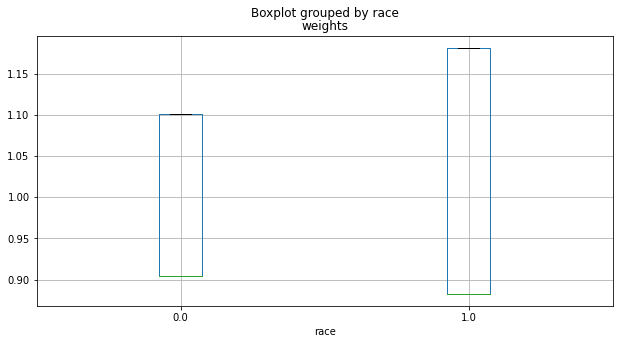

In [18]:
log_reg_RW = Reweighing(unpriv_group, priv_group).fit(train_data)
transformed_data = log_reg_RW.transform(train_data)
display(train_data.instance_weights.mean(), train_data.instance_weights.std())
display(transformed_data.instance_weights.mean(), transformed_data.instance_weights.std())
t_data = train_data.convert_to_dataframe()[0]
t_data["weights"] = transformed_data.instance_weights
t_data_blacks = t_data[t_data.race == 0]
t_data_whites = t_data[t_data.race == 1]
print(t_data_blacks.weights.describe())
print(t_data_whites.weights.describe())
t_data.boxplot(["weights"], by="race", figsize=(10, 5))
plt.show()


In [19]:
data = train_data.convert_to_dataframe()[0]
X, y = data.drop(["two_year_recid"], axis=1), data["two_year_recid"]
log_reg_all = LogisticRegression().fit(X, y, sample_weight=transformed_data.instance_weights)

t_data = test_data.convert_to_dataframe()[0]
X_, y_ = t_data.drop(["two_year_recid"], axis=1), t_data["two_year_recid"]
pred_ = log_reg_all.predict(X_)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)
tmp = t_data.copy()
tmp["two_year_recid"] = pred_

parity_diff = compute_statistical_parity(tmp, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data, pred_, unpriv_group, priv_group)
all_results.append(("Reweighting", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")
bag += [X_, y_, pred_]

Mean difference (statistical parity difference) = 0.0010330341221628236
The precision is 0.6543321299638989.
The recall is 0.5753968253968254.
The F1 is 0.612331081081081.
The accuracy is 0.6521409624857901.


In [20]:
# tmp = BinaryLabelDatasetMetric()
log_reg_RW = Reweighing(unpriv_group, priv_group).fit(train_data)
transformed_data = log_reg_RW.transform(train_data)

data = train_data.convert_to_dataframe()[0]
X, y = data.drop(["two_year_recid", "race"], axis=1), data["two_year_recid"]
log_reg_all = LogisticRegression().fit(X, y, sample_weight=transformed_data.instance_weights)

t_data = test_data.convert_to_dataframe()[0]
X_, y_ = t_data.drop(["two_year_recid", "race"], axis=1), t_data["two_year_recid"]
pred_ = log_reg_all.predict(X_)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)
tmp = t_data.copy()
tmp["two_year_recid"] = pred_

parity_diff = compute_statistical_parity(tmp, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data, pred_, unpriv_group, priv_group)
all_results.append(("Reweighting without Race", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")
bag += [X_, y_, pred_]

Mean difference (statistical parity difference) = -0.21913077643787593
The precision is 0.6781716417910447.
The recall is 0.5769841269841269.
The F1 is 0.6234991423670667.
The accuracy is 0.667298219022357.


In [21]:
data = train_data.convert_to_dataframe()[0]
X, y = data.drop(["two_year_recid"], axis=1), data["two_year_recid"]
log_reg_all = LogisticRegression().fit(X, y)

# =======================================
t_data_train = train_data.convert_to_dataframe()[0]
X_, y_ = t_data_train.drop(["two_year_recid"], axis=1), t_data_train["two_year_recid"]
pred_ = log_reg_all.predict(X_)

t_data_train_true = train_data.copy(deepcopy=True)
t_data_train_pred = train_data.copy(deepcopy=True)
t_data_train_pred.labels = pred_.reshape(-1, 1)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)

parity_diff = compute_statistical_parity(t_data_train_pred, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data_train_true, pred_, unpriv_group, priv_group)
all_results.append(("Metrics on Training Data", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")

# =======================================
t_data_test = test_data.convert_to_dataframe()[0]
X_, y_ = t_data_test.drop(["two_year_recid"], axis=1), t_data_test["two_year_recid"]
pred_ = log_reg_all.predict(X_)

t_data_test_true = test_data.copy(deepcopy=True)
t_data_test_pred = test_data.copy(deepcopy=True)
t_data_test_pred.labels = pred_.reshape(-1, 1)

ps = precision_score(y_, pred_)
rs = recall_score(y_, pred_)
fs = f1_score(y_, pred_)
as_ = accuracy_score(y_, pred_)

parity_diff = compute_statistical_parity(t_data_test_pred, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data_test_true, pred_, unpriv_group, priv_group)
all_results.append(("Metrics on Test Data", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")


Mean difference (statistical parity difference) = -0.24585888166925968
The precision is 0.663197729422895.
The recall is 0.5731807031888798.
The F1 is 0.6149122807017544.
The accuracy is 0.667298219022357.
Mean difference (statistical parity difference) = -0.23669175204763204
The precision is 0.6821631878557874.
The recall is 0.5706349206349206.
The F1 is 0.6214347450302506.
The accuracy is 0.6680560818491853.


In [22]:

y_valid_pred = np.zeros_like(test_data.labels)

odd_equalizer_EQ = EqOddsPostprocessing(unpriv_group, priv_group).fit(t_data_train_true, t_data_train_pred)
transformed_data = odd_equalizer_EQ.predict(t_data_test_pred)

ps = precision_score(t_data_test_true.labels, transformed_data.labels)
rs = recall_score(t_data_test_true.labels, transformed_data.labels)
fs = f1_score(t_data_test_true.labels, transformed_data.labels)
as_ = accuracy_score(t_data_test_true.labels, transformed_data.labels)

parity_diff = compute_statistical_parity(transformed_data, unpriv_group, priv_group)
tpr_diff, tpr_priv, tpr_unpriv = compute_metrics(t_data_test_pred, transformed_data.labels, unpriv_group, priv_group)
all_results.append(("EqOdds Postprocessing", ps, rs, fs, as_, parity_diff, tpr_diff, tpr_priv, tpr_unpriv))

print(f"The precision is {ps}.\nThe recall is {rs}.\nThe F1 is {fs}.\nThe accuracy is {as_}.")


Mean difference (statistical parity difference) = -0.02124459757608721
The precision is 0.637125748502994.
The recall is 0.4222222222222222.
The F1 is 0.5078758949880667.
The accuracy is 0.6093217127699886.


In [23]:

col_names = "Configuration Precision Recall F1 Accuracy Stat.-Parity TPR-Diff TPR_1 TPR_0".split()
results_df = pd.DataFrame(all_results, columns=col_names)

display(results_df)
display("")
cap = "This table shows the metric results for various Logisitic Regression configurations on the Compas Dataset"
print(
    results_df.to_latex(caption=cap, label="results", header=col_names,
                        float_format="%.5f").replace("{tabular}", "{tabularx}"))


,Configuration,Precision,Recall,F1,Accuracy,Stat.-Parity,TPR-Diff,TPR_1,TPR_0
0,All Features,0.682163,0.570635,0.621435,0.668056,-0.236692,-0.155266,0.841853,0.686587
1,Without Race,0.678172,0.576984,0.623499,0.667298,-0.219131,-0.139292,0.825879,0.686587
2,Reweighting,0.654332,0.575397,0.612331,0.652141,0.001033,0.067685,0.685304,0.752988
3,Reweighting without Race,0.678172,0.576984,0.623499,0.667298,-0.219131,-0.139292,0.825879,0.686587
4,Metrics on Training Data,0.663198,0.573181,0.614912,0.667298,-0.245859,-0.166683,0.838168,0.671485
5,Metrics on Test Data,0.682163,0.570635,0.621435,0.668056,-0.236692,-0.155266,0.841853,0.686587
6,EqOdds Postprocessing,0.637126,0.422222,0.507876,0.609322,-0.021245,0.065445,0.934555,1.000000


''

\begin{table}
\centering
\caption{This table shows the metric results for various Logisitic Regression configurations on the Compas Dataset}
\label{results}
\begin{tabularx}{llrrrrrrrr}
\toprule
{} &             Configuration & Precision &  Recall &      F1 & Accuracy & Stat.-Parity & TPR-Diff &   TPR\_1 &   TPR\_0 \\
\midrule
0 &              All Features &   0.68216 & 0.57063 & 0.62143 &  0.66806 &     -0.23669 & -0.15527 & 0.84185 & 0.68659 \\
1 &              Without Race &   0.67817 & 0.57698 & 0.62350 &  0.66730 &     -0.21913 & -0.13929 & 0.82588 & 0.68659 \\
2 &               Reweighting &   0.65433 & 0.57540 & 0.61233 &  0.65214 &      0.00103 &  0.06768 & 0.68530 & 0.75299 \\
3 &  Reweighting without Race &   0.67817 & 0.57698 & 0.62350 &  0.66730 &     -0.21913 & -0.13929 & 0.82588 & 0.68659 \\
4 &  Metrics on Training Data &   0.66320 & 0.57318 & 0.61491 &  0.66730 &     -0.24586 & -0.16668 & 0.83817 & 0.67148 \\
5 &      Metrics on Test Data &   0.68216 & 0.57063 & 0.62143

 # Discussion

 **Report**
 * Shortly discuss your results. For example, how do the different classifiers compare against each other?
 * Also include a short ethical discussion (1 or 2 paragraphs) reflecting on these two aspects: 1) The use of a ML system to try to predict recidivism; 2) The public release of a dataset like this.
